In [2]:
!pip install seqeval
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
from tensorflow.python.keras import backend as K
from seqeval.metrics import accuracy_score
from seqeval.metrics import f1_score
from seqeval.metrics import precision_score
from seqeval.metrics import recall_score
from seqeval.metrics import classification_report as seqeval_cs
from sklearn.metrics import classification_report as sklearn_cs
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

You should consider upgrading via the 'e:\anaconda\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ctejk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:

def _large_compatible_negative(tensor_type):
  """Large negative number as Tensor.
  This function is necessary because the standard value for epsilon
  in this module (-1e9) cannot be represented using tf.float16
  Args:
    tensor_type: a dtype to determine the type.
  Returns:
    a large negative number.
  """
  if tensor_type == dtypes.float16:
    return dtypes.float16.min
  return -1e9

class Softmax(tf.keras.layers.Layer):  
# Softmax from TF 2.4.0, if you are already using TF 2.4.0, no need for this
    def __init__(self, axis=-1, **kwargs):
        super(Softmax, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis

    def call(self, inputs, mask=None):
        if mask is not None:
            adder = (1.0 - math_ops.cast(mask, inputs.dtype)) * (
                _large_compatible_negative(inputs.dtype))

            inputs += adder
        if isinstance(self.axis, (tuple, list)):
            if len(self.axis) > 1:
                return math_ops.exp(inputs - math_ops.reduce_logsumexp(
                    inputs, axis=self.axis, keepdims=True))
            else:
                return K.softmax(inputs, axis=self.axis[0])
        return K.softmax(inputs, axis=self.axis)

    def get_config(self):
        config = {'axis': self.axis}
        base_config = super(Softmax, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @tf_utils.shape_type_conversion
    def compute_output_shape(self, input_shape):
        return input_shape


def masked_softmax_cross_entropy_loss(y_true,y_pred): 
    masked_pred = tf.boolean_mask(y_pred,y_pred._keras_mask)
    masked_true = tf.boolean_mask(y_true,y_pred._keras_mask)

    loss = tf.math.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(masked_true,masked_pred))
    return(loss)

    
def build_word_vocab(corpus,pad_index=0,pad_token="<PAD>",unk_index=1,unk_token="<UNK>"):  
# Builds word level vocabulary dictionary from given corpus    

  word_to_index = {}
  index_to_word = {}
  word_to_index[pad_token] = pad_index  
  word_to_index[unk_token] = unk_index
  index_to_word[pad_index] = pad_token
  index_to_word[unk_index] = unk_token   
  index = 0
  if index == pad_index:
    index += 1
    if index == unk_index:
      index += 1 
  if index == unk_index:
    index += 1
    if index == pad_index:
      index += 1 
  for string in corpus:
    # tokens = word_tokenize(str(string).lower())
    tokens = string
    for token in tokens:
      if token not in word_to_index:      
        word_to_index[token] = index
        index_to_word[index] = token
        index += 1
        if index == pad_index:
          index += 1
          if index == unk_index:
            index += 1 
        if index == unk_index:
          index += 1
          if index == pad_index:
            index += 1 
  return word_to_index,index_to_word

def build_char_vocab(corpus,pad_index=0,pad_token="<PAD>",unk_index=1,unk_token="<UNK>"):  
# Builds character level vocabulary dictionary from given corpus      
    
    char_to_index = {}
    index_to_char = {}
    char_to_index[pad_token] = pad_index
    char_to_index[unk_token] = unk_index    
    index = 0
    if index == pad_index:
        index += 1
        if index == unk_index:
            index += 1 
    if index == unk_index:
        index += 1
        if index == pad_index:
            index += 1 
    for string in corpus:
        tokens = string
        for token in tokens:
              for char in token:
                if char not in char_to_index:      
                    char_to_index[char] = index
                    index_to_char[index] = char
                    index += 1
                    if index == pad_index:
                        index += 1
                        if index == unk_index:
                            index += 1 
                    if index == unk_index:
                        index += 1
                        if index == pad_index:
                            index += 1 
    return char_to_index,index_to_char




def to_padded_list_word(sentences,word_to_index,labels=[],pos=[],pad_cat=0,pad_token='<PAD>',
                        unk_token='<UNK>',pos_pad=0,max_seq_len=1000):
# Creates a 2d word level padded sequence from a given list of tokenized sentences. This also creates
# masks to be propagated through the neural net. Masks are important to avoid processing the pads in 
# a padded sequence, and helps in stopping backprop loss from pads. This code is NOT optimized for 
# performance.
    
    seq_len = 0
    for tokens in sentences:
        if len(tokens) > seq_len:
            seq_len = len(tokens)
    # print(seq_len)
    if max_seq_len < seq_len:
        seq_len = max_seq_len

    pad_index = word_to_index[pad_token]
    unk_index = word_to_index[unk_token]
    sents = []
    labels_sents = []
    pos_sents = []
    mask_sents = []
    p = 0
    for tokens in sentences:
        if len(tokens) < 0:
            continue    
        sent = []
        labels_words = []
        pos_words = []
        mask_words = []
        q = 0
        for word in tokens:
            try:    
                sent.append(word_to_index[word])
            except KeyError:
                sent.append(unk_index)
            if len(labels) > 0:
                labels_words.append(labels[p][q])
            if len(pos) > 0:
                pos_words.append(pos[p][q])          
            mask_words.append(True)
            if len(sent) == seq_len:
                sents.append(sent)
                labels_sents.append(labels_words)
                pos_sents.append(pos_words)
                mask_sents.append(mask_words)
                sent = []
                labels_words = []
                pos_words = []
            q += 1
        if len(sent) > 0:
            pad_len = seq_len-len(sent)
            sent.extend(pad_len*[pad_index])
            labels_words.extend(pad_len*[pad_cat])
            mask_words.extend(pad_len*[False])
            pos_words.extend(pad_len*[pos_pad])
            sents.append(sent)
            labels_sents.append(labels_words)
            mask_sents.append(mask_words)
            pos_sents.append(pos_words)
        p += 1  

    return(sents,labels_sents,mask_sents,pos_sents)



def to_padded_list_char(sentences,char_to_index,labels=[],pos=[],pad_cat=0,pad_token='<PAD>',
                        unk_token='<UNK>',pos_pad=0,max_seq_len=1000,max_word_len=15): 
# Creates a 3d character level padded sequence from a given list of tokenized sentences. This also creates
# masks to be propagated through the neural net. Masks are important to avoid processing the pads in 
# a padded sequence, and helps in stopping backprop loss from pads. This code is NOT optimized for 
# performance.
        
    seq_len = 0
    for string in sentences:
        if len(string) > seq_len:
            seq_len = len(string)
    if max_seq_len < seq_len:
        seq_len = max_seq_len
    max_len = []
    pad_index = char_to_index[pad_token]
    unk_index = char_to_index[unk_token]
    sents = []
    pos_sents = []
    labels_sents = []
    mask_sents = []
    p = 0
    for string in sentences:
        sent_len = seq_len    
        tokens = string
        sent = []
        pos_words = []
        labels_words = []
        mask_words = []
        q = 0
        for word in tokens:                      
            word_char = []
            for char in word:        
                try:                      
                    word_char.append(char_to_index[char])
                except KeyError:
                    word_char.append(unk_index) 
                if len(word_char) == max_word_len:
                    sent.append(word_char)
                    if len(labels) > 0:
                        labels_words.append(labels[p][q])
                    if len(pos) > 0:
                        pos_words.append(pos[p][q])         
                    mask_words.append(True)
                    word_char = []
            if len(sent) == seq_len:
                sents.append(sent)
                labels_sents.append(labels_words)
                pos_sents.append(pos_words)
                mask_sents.append(mask_words)
                sent = []
                labels_words = []
                pos_words = []
                mask_words = []
            if len(word_char) > 0:
                for i in range(max_word_len-len(word_char)):                      
                    word_char.append(pad_index)
                sent.append(word_char)
                if len(labels) > 0:
                    labels_words.append(labels[p][q])
                if len(pos) > 0:
                    pos_words.append(pos[p][q])        
                mask_words.append(True)
            q += 1

        if len(sent) > 0:
            sent_len = len(sent)
            for i in range(seq_len-sent_len):
                word_char = []
                for j in range(max_word_len):
                    word_char.append(pad_index)
                sent.append(word_char)
                labels_words.append(pad_cat)
                pos_words.append(pos_pad)
                mask_words.append(False)
            sents.append(sent)
            labels_sents.append(labels_words)            
            pos_sents.append(pos_words)
            mask_sents.append(mask_words)
        p += 1  
  
    return(sents,labels_sents,mask_sents,pos_sents)

def datagen_char(corpus,corpus_labels,corpus_pos,vocab,pad_cat,batch_size):
# Creates a character based generator to fed to the neural network

    df = pd.DataFrame({'sent':corpus})
    df['labels'] = corpus_labels
    df['pos'] = corpus_pos
    while(1):
        data = df.sample(frac = 1)
        prev_index = 0
        for index in range(batch_size,len(data),batch_size):
            x = data.iloc[prev_index:index]['sent'] 
            y = data.iloc[prev_index:index]['labels'].to_list()
            pos = data.iloc[prev_index:index]['pos'].to_list()
            x,y,mask,pos = to_padded_list_char(x,vocab,y,pos,pad_cat)
            yield ({'input_ids': np.array(x,dtype=np.float64),
                    'attention_masks': np.array(mask),
                    'pos_tags': np.array(pos,dtype=np.float64)},
                   np.array(y,dtype=np.int32))
            prev_index = index
        if prev_index < len(data):
            x = data.iloc[prev_index:len(data)]['sent']
            y = data.iloc[prev_index:len(data)]['labels'].to_list()
            pos = data.iloc[prev_index:len(data)]['pos'].to_list()
            x,y,mask,pos = to_padded_list_char(x,vocab,y,pos,pad_cat)
            yield ({'input_ids': np.array(x,dtype=np.float64),
                    'attention_masks': np.array(mask),
                    'pos_tags': np.array(pos,dtype=np.float64)},
                   np.array(y,dtype=np.int32))


def datagen_word(corpus,corpus_labels,corpus_pos,vocab,pad_cat,batch_size):
# Creates a word based generator to fed to the neural network    

    df = pd.DataFrame({'sent':corpus})
    df['labels'] = corpus_labels
    df['pos'] = corpus_pos
    while(1):
        data = df.sample(frac = 1)
        prev_index = 0
        for index in range(batch_size,len(data),batch_size):
            x = data.iloc[prev_index:index]['sent'] 
            y = data.iloc[prev_index:index]['labels'].to_list()
            pos = data.iloc[prev_index:index]['pos'].to_list()
            x,y,mask,pos = to_padded_list_word(x,vocab,y,pos,pad_cat)
            yield ({'input_ids': np.array(x,dtype=np.float64),
                    'attention_masks': np.array(mask),
                    'pos_tags': np.array(pos,dtype=np.float64)},
                   np.array(y,dtype=np.int32))
            prev_index = index
        if prev_index < len(data):
            x = data.iloc[prev_index:len(data)]['sent']
            y = data.iloc[prev_index:len(data)]['labels'].to_list()
            pos = data.iloc[prev_index:len(data)]['pos'].to_list()
            x,y,mask,pos = to_padded_list_word(x,vocab,y,pos,pad_cat)
            yield ({'input_ids': np.array(x,dtype=np.float64),
                    'attention_masks': np.array(mask),
                    'pos_tags': np.array(pos,dtype=np.float64)},
                   np.array(y,dtype=np.int32))

            
def process_data(data_path,force_lowercase=False):
# Data Processing borrowed from - 
# "https://www.kaggle.com/abhishek/entity-extraction-model-using-bert-pytorch"

    df = pd.read_csv(data_path, encoding="latin-1")
    if force_lowercase:
        df['Word'] = df['Word'].str.lower()
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])


    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    pos = df.groupby("Sentence #")["POS"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, pos, tag, enc_pos, enc_tag



# Model Definition
**Defining a Bidirectional LSTM Model with Attention**

In [4]:

#MODEL
            
class label_init(tf.keras.initializers.Initializer):
    def __call__(self,shape,dtype):
        return( tf.eye(shape[0],shape[1],dtype=dtype))

class sent_char_encoder(tf.keras.layers.Layer):
    def __init__(self,vocab_dim,char_embed_size,word_embed_size):
        super().__init__(name='sent_char_encoder')
        self.embed = tf.keras.layers.Embedding(vocab_dim,char_embed_size,name='char_embeds')
        self.conv = tf.keras.layers.Conv1D(word_embed_size,3,activation='relu',use_bias=False)
        self.dense = tf.keras.layers.Dense(word_embed_size)
    def call(self,x):
        x = self.embed(x)
        x = self.conv(x)
        x = tf.math.reduce_max(x,axis=2)
        return(self.dense(x))


class BiLstm_attnv2(tf.keras.Model):
    def __init__(self,vocab_dim,char_embed_size,word_embed_size,use_char_level_embeddings=True,
                 lstm_hidden=8,num_classes=10,dropout=0.3,use_pos_features=False,num_pos=10):
        super().__init__(name='BiLstm_attnv2')
        self.num_classes = num_classes
        if use_char_level_embeddings:
            self.embed = sent_char_encoder(vocab_dim,char_embed_size,word_embed_size)
        else:
            self.embed = tf.keras.layers.Embedding(vocab_dim,word_embed_size,name='word_embeds')
        if use_pos_features:
            self.use_pos = True
            self.pos_embed = tf.keras.layers.Embedding(num_pos,num_pos,embeddings_initializer=label_init,trainable=False,dtype=tf.float32,name='pos_embeddings')
        self.lab_embed = tf.keras.layers.Embedding(num_classes,num_classes,embeddings_initializer=label_init,trainable=False,dtype=tf.float32,name='label_embeddings')
        self.encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_hidden,return_sequences=True,return_state=True),name='lstm_enc')
        self.postencoder = tf.keras.layers.Dense(2*lstm_hidden,activation='relu')
        self.drop_postencoder = tf.keras.layers.Dropout(dropout)
        self.attn_proj =  tf.keras.layers.Dense(2*lstm_hidden,use_bias=False,activation='relu')
        self.context_proj = tf.keras.layers.Dense(lstm_hidden,use_bias=False,activation='tanh')
        self.drop_context_proj = tf.keras.layers.Dropout(dropout)
        self.out =  tf.keras.layers.Dense(num_classes)   #Use this for tensorflow < 2.4.0
        
#         self.softmax = tf.keras.layers.Softmax(axis=1) #Use this if already on tensorflow >= 2.4.0
        self.softmax = Softmax(axis=1)
    def call(self,x,training=False,mask_out=True):
        x_enc = self.embed(x['input_ids'])
        if self.use_pos:
            x_pos = self.pos_embed(x['pos_tags'])
            x_enc = tf.concat([x_enc,x_pos],axis=-1)
        mask = x['attention_masks']
        softmax_mask = tf.tile(mask[...,tf.newaxis],[1,1,tf.shape(x['attention_masks'])[1]])  
        encoded = self.encoder(x_enc,mask=mask)
        attn_proj = self.attn_proj(encoded[0]) 
        decoded = self.drop_postencoder(self.postencoder(x_enc))
        e = tf.matmul(attn_proj,tf.transpose(decoded,perm=[0,2,1]))
        alpha = tf.matmul(tf.transpose(encoded[0],perm=[0,2,1]),self.softmax(e,mask=softmax_mask))
        context = tf.concat([tf.transpose(alpha,perm=[0,2,1]),decoded],axis=2)
        o = self.drop_context_proj(self.context_proj(context))
        out = self.out(o)  
        if mask_out:
            out._keras_mask = mask
        return(out)




# Loading and splitting the data
**Loading the data**

In [6]:
TRAINING_FILE = "ner_dataset.csv"
sentences, pos, tag, enc_pos, enc_tag = process_data(TRAINING_FILE)
label_array = enc_tag.classes_
pos_array = enc_pos.classes_

**Split the data into different sets and building vocabulary to be used for encoding**

In [7]:
train_test_split = 0.85
train_val_split = 0.9

train_sents = sentences[:int(train_test_split*len(sentences))]
train_tags = tag[:int(train_test_split*len(tag))]
train_pos = pos[:int(train_test_split*len(pos))]

test_sents = sentences[int(train_test_split*len(sentences)):]
test_tags = tag[int(train_test_split*len(tag)):]
test_pos = pos[int(train_test_split*len(pos)):]

val_sents = train_sents[int(train_val_split*len(train_sents)):]
val_tags = train_tags[int(train_val_split*len(train_tags)):]
val_pos = train_pos[int(train_val_split*len(train_pos)):]

train_sents = train_sents[:int(train_val_split*len(train_sents))]
train_tags = train_tags[:int(train_val_split*len(train_tags))]
train_pos = train_pos[:int(train_val_split*len(train_pos))]

cti,itc = build_char_vocab(train_sents,pad_index=0,pad_token="<PAD>",unk_index=1,unk_token="<UNK>")
wti,itw = build_word_vocab(train_sents,pad_index=0,pad_token="<PAD>",unk_index=1,unk_token="<UNK>")
print(len(train_sents),len(val_sents),len(test_sents))

36688 4077 7194


# Training the Model
**Defining training parameters and training the model using early stopping**

In [11]:
use_char_level_model = True
use_pos_features = True

if use_char_level_model:
    datagen = datagen_char
    vocab = cti
else:
    datagen = datagen_word
    vocab = wti
    
vocab_dim = len(vocab)
batch_size = 64
train_steps = int(len(train_sents)/batch_size)
test_steps = int(len(test_sents)/batch_size)
val_steps = int(len(val_sents)/batch_size)
gen_train = datagen(train_sents,train_tags,train_pos,vocab,16,batch_size)
gen_test = datagen(test_sents,test_tags,test_pos,vocab,16,batch_size)
gen_val = datagen(val_sents,val_tags,val_pos,vocab,16,batch_size)



epochs = 10
character_embedding_size = 256
word_embedding_size = 256
lstm_hidden_size = 256
loss_func = masked_softmax_cross_entropy_loss
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6,restore_best_weights=True)

net =  BiLstm_attnv2(vocab_dim,
                     character_embedding_size,
                     word_embedding_size,
                     lstm_hidden=lstm_hidden_size,
                     num_classes=len(label_array),
                     use_char_level_embeddings=use_char_level_model,
                     dropout=0.3,
                     use_pos_features=use_pos_features,
                     num_pos=len(pos_array))

net.compile(optimizer,loss_func,metrics=['accuracy'])

print('Training.....')
train_history = net.fit(gen_train,batch_size=batch_size,epochs=10,steps_per_  epoch=train_steps,
        validation_data=gen_val,validation_steps=val_steps,callbacks=[callback],verbose=1)
print('Finished Training !')

Training.....
Epoch 1/10
573/573 [==============================] - 913s 2s/step - loss: 0.1335 - accuracy: 0.9272 - val_loss: 0.0881 - val_accuracy: 0.9500
Epoch 2/10
573/573 [==============================] - 746s 1s/step - loss: 0.0746 - accuracy: 0.9562 - val_loss: 0.0623 - val_accuracy: 0.9614
Epoch 3/10
573/573 [==============================] - 751s 1s/step - loss: 0.0574 - accuracy: 0.9649 - val_loss: 0.0540 - val_accuracy: 0.9665
Epoch 4/10
573/573 [==============================] - 732s 1s/step - loss: 0.0523 - accuracy: 0.9675 - val_loss: 0.0521 - val_accuracy: 0.9680
Epoch 5/10
573/573 [==============================] - 723s 1s/step - loss: 0.0482 - accuracy: 0.9694 - val_loss: 0.0519 - val_accuracy: 0.9684
Epoch 6/10
573/573 [==============================] - 699s 1s/step - loss: 0.0455 - accuracy: 0.9706 - val_loss: 0.0488 - val_accuracy: 0.9690
Epoch 7/10
573/573 [==============================] - 753s 1s/step - loss: 0.0433 - accuracy: 0.9721 - val_loss: 0.0498 - val_ac

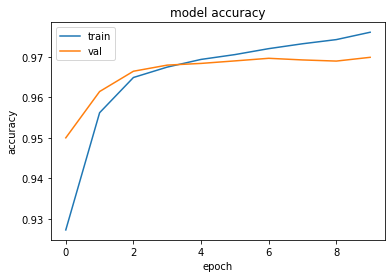

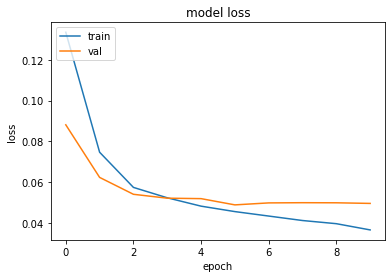

In [12]:
from matplotlib import pyplot as plt
history = train_history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing the Model
**Running the model on test data and collecting all the true labels and predicted labels for the test data to be used for calculating metrics like accuracy, precision, recall and f1 score**

In [14]:
#Test Loop
i=0
true = []
pred = []
for data in gen_test:            
    x = data[0]
    y = data[1]               
    y_pred = net(x, training = False)  # Forward pass  
    masked_pred = tf.boolean_mask(y_pred,y_pred._keras_mask)
    masked_y = tf.boolean_mask(y,y_pred._keras_mask)
    label_true = label_array[masked_y.numpy().astype(int)]
    label_pred = label_array[np.argmax(masked_pred.numpy(),axis=-1).astype(int)]
    true += label_true.tolist()
    pred += label_pred.tolist()
    i+=1
    if i > test_steps:
        break 


In [15]:
print(sklearn_cs(true,pred))

              precision    recall  f1-score   support

       B-art       0.33      0.03      0.06        59
       B-eve       0.53      0.34      0.41        56
       B-geo       0.85      0.91      0.88      5688
       B-gpe       0.98      0.92      0.95      2557
       B-nat       0.33      0.13      0.19        30
       B-org       0.77      0.69      0.73      3006
       B-per       0.81      0.82      0.81      2488
       B-tim       0.93      0.86      0.89      3044
       I-art       0.67      0.06      0.11        33
       I-eve       0.48      0.28      0.35        39
       I-geo       0.82      0.77      0.79      1145
       I-gpe       0.73      0.26      0.38        31
       I-nat       0.33      0.06      0.11        16
       I-org       0.78      0.75      0.77      2424
       I-per       0.82      0.90      0.86      2500
       I-tim       0.78      0.68      0.73       941
           O       0.99      0.99      0.99    132426

    accuracy              

**Fortunately, 'O' tags can be ignored, as they are predicted with almost perfect accuracy and we can remove them from the metrics. This helps us focus on the entities of interest and how our model performs for them. I will be using Seqeval library to calculate this based on Conlleval script**

In [16]:
print(seqeval_cs([true],[pred]))

              precision    recall  f1-score   support

         art       0.25      0.03      0.06        59
         eve       0.43      0.32      0.37        56
         geo       0.82      0.89      0.86      5688
         gpe       0.97      0.92      0.94      2557
         nat       0.33      0.17      0.22        30
         org       0.64      0.64      0.64      3006
         per       0.69      0.74      0.71      2488
         tim       0.85      0.83      0.84      3044

   micro avg       0.79      0.81      0.80     16928
   macro avg       0.62      0.57      0.58     16928
weighted avg       0.79      0.81      0.80     16928



**Above scores have humbled our expectations and shows the true prediction power of our model. True may be a very strong term as we have literally removed the majority class from the metrics.**

# Random predictions
**Lets see some randomly chosen predictions from the test data**

In [22]:
# Randomly selects a sentence from the test data and displays the predictions
index = np.random.randint(len(test_sents))
statements = [test_sents[index]]
pos = [test_pos[index]]
x,y,mask,pos = to_padded_list_char(statements,cti,[],pos,0)
x = np.array(x,dtype=np.float64)
mask = np.array(mask)
pos = np.array(pos)
input_seq = {'input_ids': np.array(x,dtype=np.float64),
             'attention_masks': np.array(mask),
             'pos_tags': np.array(pos,dtype=np.float64)}
labels = net(input_seq)

for i in range(len(statements)):
    print(statements[i])
    print(label_array[np.argmax(labels[i],axis=-1)])
    

['VOA', "'s", 'Chris', 'Simkins', 'reports', 'on', 'how', 'one', 'homeowner', 'in', '[', 'the', 'southern', 'US', 'state', 'of', ']', 'Virginia', 'is', 'fighting', 'to', 'keep', 'his', 'home', '.']
['B-org' 'O' 'B-per' 'I-per' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-geo'
 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
